# HpBandSter + CAVE

We will present you a example procedure of how to efficiently optimize a algorithm using our frameworks
<a href="https://github.com/automl/CAVE" target="_blank">CAVE</a> and <a href="https://github.com/automl/HpBandSter" target="_blank">HpBandSter</a>.

## Short introduction

### HpBandSter

HpBandSter (HyperBand on STERoids) implements recently published methods for optimizing hyperparameters of machine learning algorithms. We designed HpBandSter such that it scales from running sequentially on a local machine to running on a distributed system in parallel

One of the implemented algorithms is BOHB, which combines Bayesian Optimization and HyperBand to efficiently search for well performing configurations. Learn more about this method by reading out paper, published at <a href="http://proceedings.mlr.press/v80/falkner18a.html" target="_blank">ICML 2018</a>

### CAVE

CAVE stands for Configuration Assessment, Visualization and Evaluation. It is designed to create comprehensive reports about an optimization process. The resulting figures and interactive plots can be used to gain insights in the parameter importance, feature importance, search behaviour and quality. For a detailed report on the various analysis methods that CAVE offers, please see the documentation.
For HpBandSter/BOHB CAVE offers a report that can be used to compare the optimization process over the individual budgets. Each analysis method is performed for each individual budget.

**NOTE:** This notebook is just a simple example of how to combine those tools. For a more detailed insight into the frameworks, please take a look at the corresponding documentation.
- <a href="https://automl.github.io/CAVE/stable/" target="_blank">CAVE-Documentation</a>
- <a href="https://automl.github.io/HpBandSter/build/html/index.html" target="_blank">HpBandSter-Documentation</a>


## The workflow


In the next section, we guide you through the following tutorial:
#### 1) Run BOHB on a given algorithm to optimize and a *configuration space*. 
This step contains: 
1. Setting up a worker, which is responsible for evaluating a given model with a single configuration on a single budget at a time. Here, the model is a simple scipy implementation of a SVM classifing the MNIST-dataset.
2. Defining a configuration space for the classifier using the <a href="https://github.com/automl/ConfigSpace" target="_blank">ConfigSpace module</a>.
3. Setting up a nameserver, which organizes multiple workers and starting the optimizer, here BOHB.

#### 2) We will pass the BOHB results into the CAVE-tool.
It will give insights into the 
1. Parameter importance, 
2. performance analysis,
3. feature analysis and 
4. configuration behaviour.

### 1.1) Setting up a worker class
The Worker is responsible to evaluate a hyperparameter setting and returning the associated loss that is minimized. By deriving from the base class, encoding a new problem consists of implementing two methods: **__init__** and **compute**. The first allows to perform inital computations, e.g. loading the dataset, when the worker is started, while the latter is called repeatedly called during the optimization and evaluates a given configuration yielding the associated loss.

In the implementation below the following steps are perfomed: 
+ inherit from the hpbandster.core.worker class
+ In the *__init__*-method, the mnist data is loaded
+ overwrite the *compute* methode: the training of the model happens here
+ **NOTE**: make sure that the returned dictionary contains the fields *loss* and *info*

In [3]:
from sklearn import datasets, neural_network, metrics
from hpbandster.core.worker import Worker

class MyWorker(Worker):
    def __init__(self, *args, **kwargs):
        super(MyWorker, self).__init__(*args, **kwargs)
        # load the MNIST dataset
        digits = datasets.load_digits()
        n_samples = len(digits.images)
        data = digits.images.reshape((n_samples, -1))
        
        # split it into training and test set.
        self.train_x = data[:n_samples // 2]
        self.train_y = digits.target[:n_samples // 2]
        self.test_x = data[n_samples // 2:]
        self.test_y = digits.target[n_samples // 2:]

    def compute(self, config, budget, *args, **kwargs):
        """
        Simple example for a compute function. It'll be repeatedly called by the optimizer. 
        
        Args:
            config: dictionary containing the sampled configurations by the optimizer
            budget: (float) amount of time/epochs/etc. the model can use to train

        Returns:
            dictionary with mandatory fields:
                'loss' (scalar)
                'info' (dict)
        """
        beta_1 = 0  if 'beta_1' not in config else config['beta_1']
        beta_2 = 0  if 'beta_2' not in config else config['beta_2']
        
        clf = neural_network.MLPClassifier(max_iter=int(budget),
                                           learning_rate='constant',
                                           learning_rate_init=config['learning_rate_init'],
                                           activation=config['activation'],
                                           solver=config['solver'],
                                           beta_1=beta_1, 
                                           beta_2=beta_2
                                          )
        clf.fit(self.train_x, self.train_y)
        
        predicted = clf.predict(self.test_x)
        loss_train = metrics.log_loss(self.train_y, clf.predict_proba(self.train_x))
        loss_test = metrics.log_loss(self.test_y, clf.predict_proba(self.test_x))

        accuracy_train = clf.score(self.train_x, self.train_y)
        accuracy_test = clf.score(self.test_x, self.test_y)
        
        return ({
            'loss': loss_train,  # this is the a mandatory field to run hyperband
            'info': {'loss_train': loss_train,
                     'loss_test': loss_test,
                     'accuracy_train': accuracy_train,
                     'accuracy_test': accuracy_test,
                    }  # can be used for any user-defined information - also mandatory
        })

### 1.2) ConfigSpace:
Every problem needs a description of the search space to be complete. In HpBandSter, a ConfigurationSpace-object defining all hyperparameters, their ranges, and potential dependencies between them.

In our example here, the search space consists of the hyperparameters:

|         Name        |     Type    |      Values      |     Condition    |
|:-------------------:|:-----------:|:----------------:|:----------------:|
| activation-function | categorical | {'relu', 'tanh'} |                  |
|    learning-rate    |    float    |   [1e-6 - 1e-2]  |                  |
|        solver       | categorical |  {'sgd', 'adam'} |                  |
|        beta_1       |    float    |      [0, 1]      | solver == 'adam' |
|        beta_2       |    float    |      [0, 1]      | solver == 'adam' |

In [4]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

def sample_configspace():
    config_space = CS.ConfigurationSpace()
    config_space.add_hyperparameter(CSH.CategoricalHyperparameter('activation', ['tanh', 'relu']))
    config_space.add_hyperparameter(CS.UniformFloatHyperparameter('learning_rate_init', lower=1e-6, upper=1e-2, log=True))
    
    solver = CSH.CategoricalHyperparameter('solver', ['sgd', 'adam'])
    config_space.add_hyperparameter(solver)
    
    beta_1 = CS.UniformFloatHyperparameter('beta_1', lower=0, upper=1)
    config_space.add_hyperparameter(beta_1)
    
    condition = CS.EqualsCondition(beta_1, solver, 'adam')
    config_space.add_condition(condition)
    
    beta_2 = CS.UniformFloatHyperparameter('beta_2', lower=0, upper=1)
    config_space.add_hyperparameter(beta_2)
    
    condition = CS.EqualsCondition(beta_2, solver, 'adam')
    config_space.add_condition(condition)
    
    return config_space

### 1.3) Setting up the HpBandSter Nameserver and starting the optimization run

**NOTE:** Unfortunately, the configuration space is *not saved automatically* to file but this step is mandatory for the analysis with CAVE.  
We recommend to save the configuration space every time you use BOHB.
We do this by using the ConfigSpace-to-json-writer.

#### Step 1:
To initiate the communication between the worker(s) and the optimizer, HpBandSter requires a nameserver to be present. This is a small service that keeps track of all running processes and their IP addresses and ports.

It could be a 'static' server with a permanent address, but here it will be started for the local machine with a random port. 

The run_id is used to identify individual runs and needs to be given to all other components as well (see below).

#### Step 2: 
The worker implements the actual problem that is optimized. Its 'compute'-method will be called later by the BOHB-optimizer repeatedly with the sampled configurations and return the computed loss (and additional information).

#### Step 3:  
In the last of the 3 Steps, we create an optimizer object. The optimizer decides which configurations are evaluated, and how the budgets are distributed. It samples configurations from the ConfigurationSpace, using succesive halving. 
To take advantage of lower fidelity approximation, i.e. budgets lower than *max_budget*, those lower accuracy evaluations have to be meaningful. As these budgets can mean very different things (epochs of training a neural network, number of data points to train the model, or number of cross-validation folds to name a few), these have to be user specified. This is done by two parameters, called *min_budget* and *max_budget* for all optimizers. For better speed ups, the lower budget should be as small as possible while still being informative. By informative, we mean that the performance is a ok indicator for the loss on higher budgets. 

**NOTE:** BOHB does not build a new model at the beginning of every SuccessiveHalving run. Instead it collects all evaluations on all budgets and uses the largest budget with enough evaluations as a base for future evaluations.  

#### Step 4:
After the run is finished, the services started above need to be shutdown. This ensures that the worker, the nameserver and the master all properly exit and no (daemon) threads keep running afterwards. In particular we shutdown the optimizer (which shuts down all workers) and the nameserver.
After a run is finished, one might be interested in all kinds of information. HpBandSter offers full access to all evaluated configurations including timing information and potential error messages for failed runs.
In this example, we simply look up the best configuration (called incumbent), count the number of configurations and evaluations.

In [5]:
import os
import logging
logging.basicConfig(level=logging.INFO)

from ConfigSpace.read_and_write import pcs_new
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres


from hpbandster.optimizers import BOHB as BOHB

# Create a configuration space
config_space = sample_configspace()

# Write the ConfigSpace for later use to file
out_dir = 'workflow_result'
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, 'configspace.pcs'), 'w') as fh:
    fh.write(pcs_new.write(config_space))

# Log the optimization results for later analysis
result_logger = hpres.json_result_logger(directory=out_dir, overwrite=True)
    
# Every run has to have a unique (at runtime) id.
run_id = '0'

# Step 1: Set up the nameserver
NS = hpns.NameServer(run_id=run_id, host='localhost', port=0)
ns_host, ns_port = NS.start()

# Step 2: Connect the worker with the nameserver
w = MyWorker(nameserver=ns_host,
             nameserver_port=ns_port,
             run_id=run_id,  # unique Hyperband run id (same as nameserver's)
            )
w.run(background=True)

# Step 3: Create the optimizer object and run it
bohb = BOHB(  configspace=config_space,
              run_id=run_id,  # same as nameserver's
              eta=2, min_budget=5, max_budget=100,  # Hyperband parameters
              nameserver=ns_host,
              nameserver_port=ns_port,
              result_logger=result_logger,
              ping_interval=3600,  # how often master pings for workers (in seconds)
           )

# Then start the optimizer. The n_iterations parameter specifies
# the number of iterations to be performed in this run
res = bohb.run(n_iterations=2)

# After the optimizer run, we shutdown the master.
bohb.shutdown(shutdown_workers=True)

INFO:hpbandster:DISPATCHER: started the 'discover_worker' thread
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: start listening for jobs
INFO:hpbandster:DISPATCHER: started the 'job_runner' thread
INFO:hpbandster:DISPATCHER: Pyro daemon running on localhost:59676
INFO:hpbandster:DISPATCHER: discovered new worker, hpbandster.run_0.worker.DESKTOP-KV1H67P.1608415988
INFO:hpbandster:HBMASTER: adjusted queue size to (0, 1)
INFO:hpbandster:DISPATCHER: A new worker triggered discover_worker
INFO:hpbandster:HBMASTER: starting run at 1535468705.7045996
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: start processing job (0, 0, 0)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: registered result for job (0, 0, 0) 

INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: registered result for job (0, 0, 3) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: start processing job (0, 0, 5)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: registered result for job (0, 0, 5) with dispatcher
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: start processing job (0, 0, 7)
C:\Users\Philipp\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: registered result for job (0, 0

[[0.         0.99350633 1.         0.86538002 0.61996657]
 [0.         0.87372611 1.         0.44715457 0.47975806]
 [0.         0.88044106 1.         0.47676305 0.71592325]
 [1.         0.76355038 1.         0.11566473 0.03196209]
 [0.         0.82833534 1.         0.53123841 0.67118551]
 [0.         0.82032556 1.         0.58478843 0.64664503]]
[[0.         0.81738103 1.         0.71362197 0.67817373]
 [0.         0.81596286 1.         0.61733232 0.42751703]
 [0.         0.82578798 1.         0.42932803 0.58552529]
 [0.         0.80866376 1.         0.67103611 0.87021057]
 [0.         0.77144743 1.         0.44132936 0.95769447]
 [0.         0.83808672 0.         0.65448923 0.35634805]
 [0.         0.30555762 1.         0.88732838 0.85928481]
 [0.         0.22773261 1.         0.65448923 0.35634805]]
[0.32372659 0.06173875 0.001      0.19183861 0.20270503]
[0.001      0.20023808 0.27824128 0.11597421 0.19101884]
INFO:hpbandster.run_0.worker.DESKTOP-KV1H67P.16084:WORKER: start process

A total of 24 unique configurations where sampled.
A total of 46 runs where executed.
Best configuration found: {'activation': 'tanh', 'learning_rate_init': 0.003324790023143092, 'solver': 'adam', 'beta_1': 0.47676304566040895, 'beta_2': 0.7159232476419948}


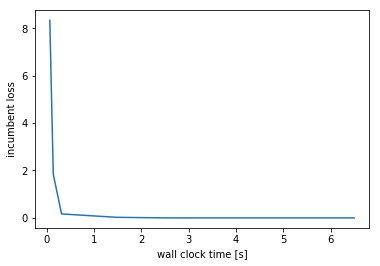

In [6]:
# Step 4 Plotting the results

# The returned result object holds informations about the optimization run
# like the incumbent (=best) configuration.
id2config = res.get_id2config_mapping()
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(res.get_all_runs()))
print('Best configuration found: {}'.format(id2config[res.get_incumbent_id()]['config']))

# The incumbent trajectory is a dictionary with all the configuration IDs, the times the runs
# finished, their respective budgets, and corresponding losses.
# It's used to do meaningful plots of the optimization process.
incumbent_trajectory = res.get_incumbent_trajectory()

import matplotlib.pyplot as plt
plt.plot(incumbent_trajectory['times_finished'], incumbent_trajectory['losses'])
plt.xlabel('wall clock time [s]')
plt.ylabel('incumbent loss')
plt.show()

## Using the results in CAVE

### 2.1) Creating a HTML-report with CAVE

Creating the report with CAVE is very straight-forward. Simply provide the output-directory of the BOHB-analysis in CAVE's `--folders` argument and specify `--file_format` as `BOHB`. You can do this by commandline ('!' simply executes the command as if it was executed on the command line):


In [ ]:
! cave --folders workflow_result --file_format BOHB --output CAVE-workflow-result --verbose_level INFO

After CAVE finished the report, you can have a look at it with your favorite browser.

In [ ]:
! firefox CAVE-workflow-result/report.html

### 2.2) Using CAVE from within Python

Of course you can use CAVE on a module-level. Import and instantiate it (very similarily to the commandline). By default, CAVE even outputs all analysis results in a jupyter-cell-compatible way. Of course, the HTML-report is built meanwhile, so you don't have to run time-consuming analyzing-methods repeatedly.

In [ ]:
from cave.cavefacade import CAVE

cave = CAVE(folders=["workflow_result"],
            output_dir="test_jupyter",
            ta_exec_dir=["."],
            file_format='BOHB',
            #verbose_level='DEV_DEBUG'
           )

The most interesting plot for BOHB might be a visualization of the learning curves:

In [ ]:
cave.bohb_learning_curves()

We can access the individual budgets via the 'run'-keyword-argument of each analysis-method.

In [ ]:
cave.print_budgets()

In [ ]:
cave.overview_table(run='budget_12.5')

For each budget, we can compare the default against the incumbent:

In [ ]:
cave.compare_default_incumbent(run='budget_25.0')

In [ ]:
cave.performance_table(run='budget_25.0')

For parameter-importance analysis, CAVE uses <a href="https://github.com/automl/ParameterImportance" target="_blank">PIMP</a> , a package that provides multiple approaches to parameter-importance analysis. We can easily invoke them via CAVE, of course. To estimate the importance, random forests are used to predict performances of configurations that were not executed. This is difficult for big budgets with few configurations.

In [ ]:
cave.cave_fanova(run='budget_12.5')

In [ ]:
cave.cave_ablation(run='budget_12.5')

In [ ]:
cave.local_parameter_importance(run='budget_12.5')

For each budget, we can compare the different parameter-importance-methods that have already been run:

In [ ]:
cave.pimp_comparison_table(run='budget_12.5')

To analyze BOHB's behaviour, we can check out the configurator footprint, cost-over-time and parallel coordinated parameters:

In [ ]:
cave.configurator_footprint(run='budget_12.5', time_slider=True, num_quantiles=5)

In [ ]:
cave.cost_over_time(run="budget_25.0")

In [ ]:
cave.parallel_coordinates(run='budget_12.5')